Notebook to check surface flux statistics to see if min-sfc-wind setting is having an effect.

James Ruppert  
11/7/2024

In [1]:
from netCDF4 import Dataset
import numpy as np
from matplotlib import rc#, ticker, colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wrf import getvar, ALL_TIMES
import subprocess
import pandas as pd
from read_wrf_ideal import *
import seaborn as sns

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [32]:
def add_var(figdata, ax, itest):
    ax.set_title(figdata['vartag'])
    ax.set_ylabel('Density')
    ax.set_xlabel('Units = '+figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], label=figdata['test'],
                 stat='density')
    # default_colors = sns.color_palette()
    # median = np.nanmedian(figdata['pltvar'])
    # ax.axvline(median, color=default_colors[itest])#, label='Median = '+str(round(median, 2)))
    ax.legend()

In [48]:
scdir = "/glade/derecho/scratch/ruppert/wrf-ideal/"
wrftag = "wrfout_d01"

tests_compare = ['smalldom', 'fluxtest', 'fluxtest2']
wrfdir = scdir+tests_compare[0]+"/"
wrffiles = get_wrf_file_list(wrfdir, wrftag)
ds = Dataset(wrffiles[16])
hfx = getvar(ds, 'HFX', timeidx=ALL_TIMES).data
qfx = getvar(ds, 'QFX', timeidx=ALL_TIMES).data*lv
ds.close()


In [47]:
print(hfx.min())
print(qfx.min())

4.6222277
62.54756


In [49]:
print(hfx.min())
print(qfx.min())

4.463954
61.492714


/glade/derecho/scratch/ruppert/wrf-ideal/smalldom/wrfout_d01_2007-06-02_00:00:00
/glade/derecho/scratch/ruppert/wrf-ideal/fluxtest/wrfout_d01_2007-06-02_00:00:00
/glade/derecho/scratch/ruppert/wrf-ideal/fluxtest2/wrfout_d01_2007-06-02_00:00:00


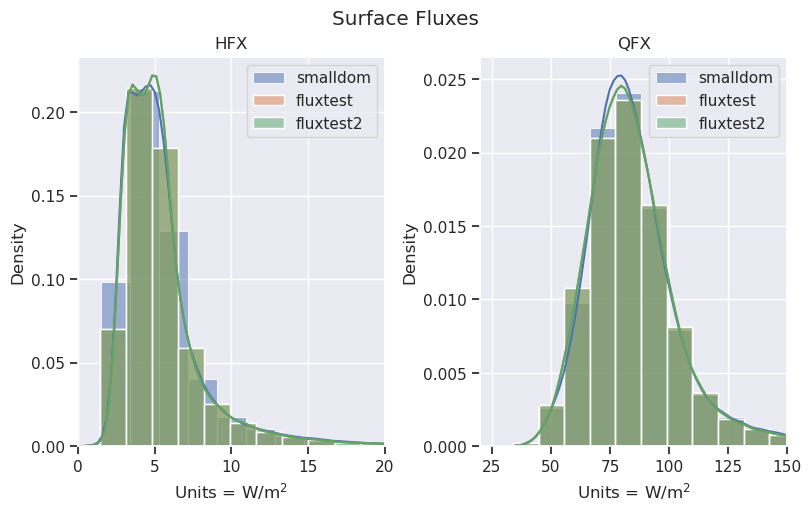

In [39]:
tests_compare = ['smalldom', 'fluxtest', 'fluxtest2']
scdir = "/glade/derecho/scratch/ruppert/wrf-ideal/"
wrftag = "wrfout_d01"

# Create figure
fig_x, fig_y = 8, 5
fig, axs = plt.subplots(1, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

plt.suptitle('Surface Fluxes')

flux_str = ['HFX','QFX']
lv = 2.5e6 # J/kg
factor = [1, lv] # to convert QFX to W/m^2

for iitest, itest in enumerate(tests_compare):

    wrfdir = scdir+itest+"/"
    wrffiles = get_wrf_file_list(wrfdir, wrftag)
    hfx = []
    qfx = []
    for ifile in wrffiles[1:2]:
        print(ifile)
        ds = Dataset(ifile)
        hfx.append(getvar(ds, flux_str[0], timeidx=ALL_TIMES).data)
        qfx.append(getvar(ds, flux_str[1], timeidx=ALL_TIMES).data*lv)
        ds.close()

    for iiflux, sfc_flux in enumerate([hfx, qfx]):

        figdata = {
            'pltvar': np.array(sfc_flux).flatten(),
            'vartag': flux_str[iiflux],
            'units': 'W/m$^2$',
            'test': itest,
            'bins': 30,
                }
        add_var(figdata, axs[iiflux], iitest)

        if iiflux == 0:
            axs[iiflux].set_xlim(0, 20)
        else:
            axs[iiflux].set_xlim(20, 150)

axs[0].legend()#loc='upper right')
plt.show()
plt.close()

## Domain-mean time series

#### Generate time series via CDO

In [6]:
varname_str = 'RAINNC,OLR,HFX,LH '
operation_str1 = 'cdo mergetime'
operation_str2 = ' -fldavg -selname,'+varname_str
timeseries_file = " "+workdir+'python/netcdf/'+test_process+'_2d_timeseries.nc'

# Create string array of file-specific commands
if do_cdo_2d:

    cdo_line = [operation_str1]
    for ifil in wrffiles:
        cdo_line.append(operation_str2+ifil)
    # Then join them into one string
    cdo_line_merged = " ".join(cdo_line)

    # Run CDO command
    # First remove file if it exists
    process = subprocess.Popen(['rm -f '+timeseries_file], shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    process = subprocess.Popen([cdo_line_merged+timeseries_file], shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    # lines = process.stdout.readlines()
    # for iline in lines:
    #     print(iline)

#### Read time series data

In [7]:
def plot_time_series(rain_ts, olr_ts, lh_ts, sh_ts, times):

        # Use Pandas to smooth via running mean
        def smooth_tser(invar, nsmooth=3):
                invar_df = pd.DataFrame(invar)
                invar_df = invar_df.rolling(window=nsmooth, center=True, closed='both', min_periods=nsmooth).mean()
                return invar_df
        n_smooth = npd*3
        rain_sm = smooth_tser(rain_ts, n_smooth)
        olr_sm = smooth_tser(olr_ts, n_smooth)
        lh_sm = smooth_tser(lh_ts, n_smooth)
        sh_sm = smooth_tser(sh_ts, n_smooth)

        # create figure
        fig, ax1 = plt.subplots(figsize=(6,3))

        # Time labels
        ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

        ax1.set_title('Time Series RCE Check')#, fontsize=20)
        # ax1.set_xlabel('Time [days]')
        ax1.set_xlabel('Date')

        ax1.set_ylabel('mm/day')
        ax1.set_ylim(0,1)

        ax1.plot(times, rain_sm, linewidth=2, label='Rain rate', color='black', linestyle='solid')

        ax2 = ax1.twinx()
        ax2.set_ylim(0,300)
        ax2.set_ylabel('W/m$^2$')

        ax2.plot(times, olr_sm, linewidth=2, label='OLR', color='blue', linestyle='solid')
        ax2.plot(times, lh_sm, linewidth=2, label='LH', color='red', linestyle='solid')
        ax2.plot(times, sh_sm, linewidth=2, label='SH', color='red', linestyle='dashed')

        plt.legend(loc="upper right")

        # figname=figdir+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        # plt.savefig(figname,dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()
        return None

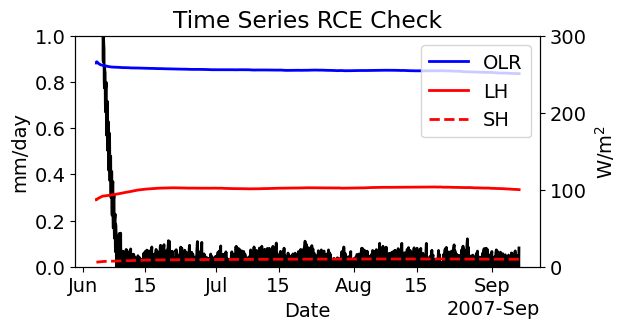

In [8]:
if do_plot_tser:

    wrffile_read = Dataset(timeseries_file)

    # Read in sfc fluxes
    for ifile in wrffiles[0:1]:
        ds = Dataset(ifile)
        hfx = getvar(ds, 'HFX', timeidx=ALL_TIMES)

    # General specs
    nt_ts = wrffile_read.dimensions['XTIME'].size
    times = np.squeeze(wrffile_read.variables['XTIME']) # minutes since model start
    # time_days = times/60/24 # days
    time_0 = np.datetime64('2007-06-01T00:00', 'm')
    times = time_0+times.astype('timedelta64[m]')

    # Read in variables

    rainnc = np.squeeze(wrffile_read.variables['RAINNC']) # accumulated rain, mm
    olr_ts = np.squeeze(wrffile_read.variables['OLR']) # W/m2
    sh_ts = np.squeeze(wrffile_read.variables['HFX']) # W/m2
    lh_ts = np.squeeze(wrffile_read.variables['LH']) # W/m2

    wrffile_read.close()

    # Rain rate as centered difference
    rain_ts=np.zeros(nt_ts)
    rain_ts[1:nt_ts-2] = (rainnc[2:nt_ts-1] - rainnc[0:nt_ts-3])*0.5
    rain_ts[[0,nt_ts-1]] = np.nan
    rain_ts *= npd # mm/output_dt --> mm/day

    plot_time_series(rain_ts, olr_ts, lh_ts, sh_ts, times)

## Prepare input_sounding

#### Generate mean profile via CDO

In [9]:
# Notes:
# Need to read/write base-state geopotential, since only perturbation is updated
# Need to add 300 K to T, which is potential temperature

varname_str = 'PSFC,Q2,PH,T,QVAPOR '
operation_str1 = 'cdo mergetime'
operation_str2 = ' -fldavg -selname,'+varname_str
basestate_file = " "+workdir+'python/netcdf/'+test_input_sounding+'_base_state.nc'
meanprof_file = " "+workdir+'python/netcdf/'+test_input_sounding+'_mean_profile_'+str(nd_avg)+'d.nc'

if do_cdo_3d:

    # Generate mean base state file for single time step (doesn't change)
    # First remove file if exists
    process = subprocess.Popen(['rm -f '+basestate_file], shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    # Generate file
    process = subprocess.Popen(['cdo fldavg -selname,PHB -seltimestep,1 '+wrffiles[0]+basestate_file], shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    lines = process.stdout.readlines()
    for iline in lines:
        print(iline)

    # File selection for averaging
    ifile_first = nd_smalldom - nd_avg # assumes these inputs are in units of days
    ifile_last = ifile_first+nd_avg
    # Check that n-files = nd_avg
    if len(wrffiles[ifile_first:ifile_last]) == nd_avg:
        print()
        print("File selection checks out!!")
        print()
    else:
        print()
        print("FIX FILE SELECTION!!")
        print()

    # Create string array of file-specific commands
    cdo_line = [operation_str1]
    for ifil in wrffiles[ifile_first:ifile_last]:
        cdo_line.append(operation_str2+ifil)
    # Then join them into one string
    cdo_line_merged = " ".join(cdo_line)

    # Run CDO command
    # First remove file if exists
    process = subprocess.Popen(['rm -f '+meanprof_file], shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    process = subprocess.Popen([cdo_line_merged+meanprof_file], shell=True, stdout=subprocess.PIPE, universal_newlines=True)
    lines = process.stdout.readlines()
    for iline in lines:
        print(iline)

#### Read mean profile and write 'input_sounding'

In [10]:
if write_input_sounding:

    # Read in base state
    basestate_read = Dataset(basestate_file)
    geop_bs = np.squeeze(basestate_read.variables['PHB']) # m2/s2
    basestate_read.close()

    # Read in main variables
    profile_read = Dataset(meanprof_file)
    psfc_read = np.squeeze(profile_read.variables['PSFC']) # Pa
    q2_read = np.squeeze(profile_read.variables['Q2']) # kg/kg
    geop_read = np.squeeze(profile_read.variables['PH']) # m2/s2
    theta_read = np.squeeze(profile_read.variables['T']) # K
    qv_read = np.squeeze(profile_read.variables['QVAPOR']) # kg/kg
    profile_read.close()

    nz_out = (theta_read.shape)[1]

    # Time averages
    psfc_mn = np.mean(psfc_read)
    q2_mn = np.mean(q2_read)
    geop_mn = np.mean(geop_read, axis=0)
    theta_mn = np.mean(theta_read, axis=0)
    qv_mn = np.mean(qv_read, axis=0)

    # Modify variables into required format & units
    psfc_mn *= 1e-2 # Pa --> hPa
    q2_mn *= 1e3 # kg/kg --> g/kg
    hght_mn = (geop_mn + geop_bs)/9.81
    theta_mn += 300 # K
    qv_mn *= 1e3 # kg/kg --> g/kg

    # Interpolate height from staggered grid
    hght_mn = (hght_mn[1:]+hght_mn[0:-1])*0.5

    # Write 'input_sounding'
    file_out = "input_sounding"
    f_out = open(file_out, 'w')
    f_out.writelines((f"{psfc_mn:.6f}", '  ', f"{sst:.1f}", '  ', f"{q2_mn:.6f}", "\n"))
    for iz in range(nz_out):
        f_out.writelines((f"{hght_mn[iz]:.6f}", '  ', f"{theta_mn[iz]:.6f}", '  ', f"{qv_mn[iz]:.6f}", '  ',
                        "0.0", '  ', "0.0", "\n"))
    f_out.close()